In [1]:
### Opening nxs

import h5py
import numpy as np
import napari

def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Find all datasets with 3 dimensions in a HDF5 file.       
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            find_datasets_with_dim_3(
                file, group=item, path=current_path, results=results
            )
        elif isinstance(item, h5py.Dataset):
            if len(item.shape) == 3:
                results.append(
                    (current_path, item.shape)
                ) 
    return results

projs_path = r"D:\SOLEIL0125\019_wholehead_3M_3\019_wholehead_3M_3\019_wholehead_3M_3.nxs"
dark_path = r"D:\SOLEIL0125\019_wholehead_3M_3\019_wholehead_3M_3\post_dark.nxs"
flat_paths = r"D:\SOLEIL0125\019_wholehead_3M_3\019_wholehead_3M_3\post_ref.nxs"

with h5py.File(projs_path, 'r') as file:
    projs_key = find_datasets_with_dim_3(file)[0][0]
    projs = np.array(file[projs_key])
print("Projections shape:", projs.shape)

with h5py.File(dark_path, 'r') as file:
    dark_key = find_datasets_with_dim_3(file)[0][0]
    dark = np.mean(np.array(file[dark_key]), axis=0)
print("Dark shape:", dark.shape)

flat = []
with h5py.File(flat_paths, 'r') as file:
    flat_key = find_datasets_with_dim_3(file)[0][0]
    flat = np.mean(np.array(file[flat_key]), axis=0)
print("Flat shape:", flat.shape)

Projections shape: (3200, 1200, 1472)
Dark shape: (1200, 1472)
Flat shape: (1200, 1472)


In [1]:
import h5py
import numpy as np

### Opening data ###

filename = r"d:\Elettra_24\eth70\B1\rawdata\B1-Eth70_Z4.5mm.tdf"
hf = h5py.File(filename,'r')
dset = hf['exchange']
white = np.median(dset['data_white'], axis=1)
print('White shape: ', white.shape)

dark = np.median(dset['data_dark'], axis=1)
print('Dark shape: ', dark.shape)
proj = dset['data']
projs=np.swapaxes(np.asarray(proj), 0, 1)
print('Data shape: ', projs.shape)

White shape:  (1548, 2045)
Dark shape:  (1548, 2045)
Data shape:  (3600, 1548, 2045)


In [ ]:
import numpy as np

projs = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_projs.npy")
projs = np.swapaxes(projs, 0, 1)
print("Projections shape:", projs.shape)
dark = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_darks.npy")
dark = np.median(dark, axis=1)
print("Dark shape:", dark.shape)
flat = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_whites.npy")
flat = np.median(flat, axis=1)
print("Flat shape:", flat.shape)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(projs, name='Projections')
viewer.add_image(dark, name='Dark')
viewer.add_image(flat, name='Flat')

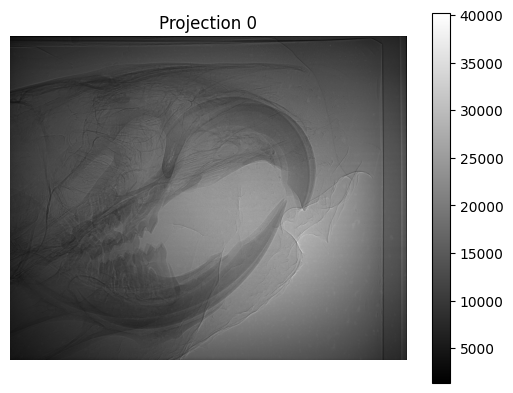

In [2]:
def display_slice(slice, title='Slice', cmap='gray', vmin=None, vmax=None, colorbar=False):
    """
    Display a slice with matplotlib dans un 1:1 aspect ratio

    Parameters
    ----------
    slice : numpy array
        Slice to display
    title : str
        Title of the plot
    cmap : str
        Color map to use

    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt

    plt.imshow(slice, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    if colorbar:
        plt.colorbar()
        
    plt.title(title)

    plt.show()

display_slice(projs[0], title='Projection 0', cmap='gray', colorbar=True)

In [3]:
### Get Center of Rotation from csv file


import pandas as pd
import os

csv_path = r"C:\Users\clement.capdeville\Documents\GitHub\SOLEIL25\part_info.csv"
part_info = pd.read_csv(csv_path)
filtered_info = part_info.loc[part_info["Path"] == os.path.basename(projs_path).split(".")[0]]
CoR = filtered_info["CoR"].values[0] if not filtered_info.empty else None
angle_padding = filtered_info["Angle"].values[0] if not filtered_info.empty else None

print("CoR:", CoR)
print("Angle padding:", angle_padding)

CoR: 95.58462688362654
Angle padding: 0.1125


Preprocessing projections: 100%|██████████| 3200/3200 [00:09<00:00, 333.72it/s]


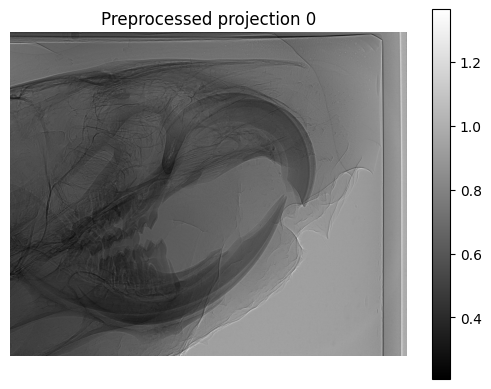

In [4]:
### Preprocessing

import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

def preprocess(proj, dark, flat):

    num = proj - dark
    den = flat - dark
    
    den[den == 0] = 1e-12
    
    return num / den

projs = np.array(Parallel(n_jobs=-1, backend='threading')(
    delayed(preprocess)(proj, dark, flat) 
    for proj in tqdm(projs, desc='Preprocessing projections')))

display_slice(projs[0], title='Preprocessed projection 0', cmap='gray', colorbar=True)

In [5]:
np.save("mbd_projs.npy", projs)

Phase retrieval: 100%|██████████| 2400/2400 [00:59<00:00, 40.18it/s]


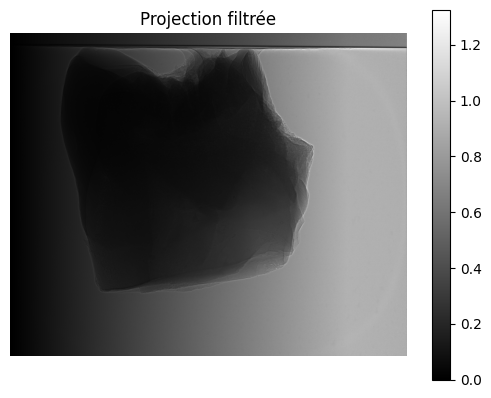

In [ ]:
import cupy as cp
from cupy.fft import fft2, ifft2
from tqdm import tqdm

PI = cp.pi
PLANCK_CONSTANT = 6.58211928e-19  # [keV*s]
SPEED_OF_LIGHT = 299792458e+2     # [cm/s]


def _wavelength(energy_keV):
    """Calcule la longueur d'onde à partir de l'énergie (en keV)."""
    return 2 * PI * PLANCK_CONSTANT * SPEED_OF_LIGHT / energy_keV


def paganin_filter(
        data, pixel_size, dist, energy, db, pad=True):
    """
    Applique la récupération de phase de Paganin généralisée (Paganin et al. 2020).
    
    Paramètres :
    ------------
    data : ndarray (num_projections, height, width)
        Projections brutes (cuPy ndarray ou NumPy converti en CuPy).
    pixel_size : float
        Taille de pixel du détecteur en cm.
    dist : float
        Distance de propagation en cm.
    energy : float
        Énergie en keV.
    db : float
        Rapport delta/beta.
    pad : bool
        Appliquer du padding anti-bordures.

    Retour :
    --------
    ndarray
        Projections récupérées en phase (mêmes dimensions que l'entrée).
    """
    # Calcule les dimensions de padding
    py, pz, pad_val = _calc_pad(data, pixel_size, dist, energy, pad)

    dx, dy, dz = data.shape
    padded_shape = (dy + 2 * py, dz + 2 * pz)

    # Grille réciproque correcte
    k_squared = _reciprocal_grid(pixel_size, *padded_shape)

    # Filtre Paganin généralisé
    wavelength = _wavelength(energy)
    alpha = db * (dist * wavelength) / (4 * PI)
    phase_filter = cp.fft.fftshift(1.0 / (1.0 + alpha * k_squared))

    # Traitement projection par projection
    prj = cp.full(padded_shape, pad_val, dtype=data.dtype)

    for m in tqdm(range(dx), desc="Phase retrieval"):
        # Insertion dans une image paddée
        prj[py:dy + py, pz:dz + pz] = cp.asarray(data[m])

        # Remplissage bordures (bord constant)
        prj = cp.pad(cp.asarray(data[m]), ((py, py), (pz, pz)), mode='reflect')

        # Filtrage Fourier
        fproj = fft2(prj)
        fproj *= phase_filter
        proj_filtered = cp.real(ifft2(fproj))

        # Découpe pour retirer le padding
        if pad:
            proj_filtered = proj_filtered[py:dy + py, pz:dz + pz]

        # Remplacement dans le volume
        data[m] = proj_filtered.get()

    return data


def _reciprocal_grid(pixel_size, nx, ny):
    """Grille réciproque correcte (k^2 = fx^2 + fy^2)."""
    fx = cp.fft.fftfreq(nx, d=pixel_size)
    fy = cp.fft.fftfreq(ny, d=pixel_size)
    fy, fx = cp.meshgrid(fy, fx)
    return fx**2 + fy**2


def _calc_pad(data, pixel_size, dist, energy, pad):
    """Calcule le padding à appliquer (si demandé)."""
    dx, dy, dz = data.shape
    wavelength = _wavelength(energy)
    py, pz, val = 0, 0, 0
    if pad:
        val = float(cp.mean((data[..., 0] + data[..., -1]) * 0.5))
        pad_width = cp.ceil(PI * wavelength * dist / pixel_size**2)
        py = int((2 ** cp.ceil(cp.log2(dy + pad_width)) - dy) * 0.5)
        pz = int((2 ** cp.ceil(cp.log2(dz + pad_width)) - dz) * 0.5)
    return py, pz, val

retrieved_projs = paganin_filter(
    projs,        # projections originales (CuPy array)
    pixel_size=12e-4,          # cm
    dist=1.2,                  # cm
    energy=40,                 # keV
    db=5,                     # delta/beta
    pad=True                   # padding pour bordures
)

display_slice(retrieved_projs[0], title='Projection filtrée', cmap='gray', colorbar=True)


In [ ]:
import math
import cupy as cp
import numpy as np
from numpy import pi
from tqdm import tqdm

def keVtoLambda(energy_kev):
    h = 6.62607015e-34  # J.s
    c = 299792458  # m/s
    energy_joules = energy_kev * 1e3 * 1.60218e-19  # J
    return h * c / energy_joules

def get_padding_size(image, energy, effective_pixel_size, distance):
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)
    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size**2))
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin
    nx_padded = 2 ** math.ceil(math.log2(nx_margin))
    ny_padded = 2 ** math.ceil(math.log2(ny_margin))
    return nx_padded, ny_padded

def padding(image, nx_padded, ny_padded):
    ny, nx = image.shape
    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left
    return cp.pad(image, ((top, bottom), (left, right)), mode='reflect')

def compute_uv_squared(shape, pixel_size):
    ny, nx = shape
    pixel_size = pixel_size
    u = cp.fft.fftshift(cp.fft.fftfreq(ny, d=pixel_size))
    v = cp.fft.fftshift(cp.fft.fftfreq(nx, d=pixel_size))
    u, v = cp.meshgrid(u, v, indexing='ij')
    return u**2 + v**2

def paganin_filter(sample_images, energy_kev, pixel_size, delta_beta, dist_object_detector, beta):
    lambda_energy = keVtoLambda(energy_kev)
    waveNumber = 2 * pi / lambda_energy
    mu = 2 * beta * waveNumber

    fftNum = cp.fft.fftshift(cp.fft.fft2(sample_images))
    uv_sqrd = compute_uv_squared(fftNum.shape, pixel_size)

    denominator = 

    # denominator = 1 + (lambda_energy * dist_object_detector * delta_beta * uv_sqrd / (4 * pi))
    # denominator = 1 + pi * delta_beta * dist_object_detector * lambda_energy * uv_sqrd
    denominator[denominator == 0] = cp.finfo(float).eps

    tmpThickness = cp.fft.ifft2(fftNum / denominator)
    img_thickness = cp.real(tmpThickness)
    img_thickness = -cp.asnumpy(cp.log(img_thickness) / mu) * 1e6
    img_thickness[img_thickness <= 0] = 1e-12

    return img_thickness

def process_projection(proj, energy, distance, beta, delta, pixel_size, nx_padded, ny_padded):
    padded_proj = padding(cp.asarray(proj), nx_padded, ny_padded)
    retrieved_proj = paganin_filter(padded_proj, energy, pixel_size, delta/beta, distance, beta)
    
    ny, nx = proj.shape
    y_margin = (ny_padded - ny) // 2
    x_margin = (nx_padded - nx) // 2
    return retrieved_proj[y_margin:y_margin+ny, x_margin:x_margin+nx]

# === Paramètres ===
energy = 40  # keV
effective_pixel_size = 11.5e-6  # m
distance = 1.2  # m
pixel_size = 12e-6  # m
delta = 1.7e-6
beta = 1.3e-8

nx = projs.shape[1]
ny = projs.shape[2]
nx_padded, ny_padded = get_padding_size(projs[0], energy, effective_pixel_size, distance)

print("delta/beta:", delta/beta)

proj = process_projection(
    projs[0],
    energy, distance,
    beta, delta, pixel_size,
    nx_padded, ny_padded
)

# retrieved_projs = np.zeros_like(projs, dtype=np.float32)
# for i in tqdm(range(projs.shape[0])):
#     retrieved_projs[i] = process_projection(
#         projs[i],
#         energy, effective_pixel_size, distance,
#         beta, delta, pixel_size,
#         nx_padded, ny_padded, uv_sqrd
#     )

display_slice(proj)

viewer = napari.Viewer()
viewer.add_image(proj, name='Projections')


In [ ]:
import napari
viewer = napari.Viewer()
napari.view_image(retrieved_projs)

In [5]:
### Double Flatfield Correction

def double_flatfield_correction(projs):
    """
    Apply double flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """

    mean_proj = np.mean(projs, axis=0)

    mean_proj[mean_proj == 0] = 1e-6

    I_corr = projs / mean_proj

    return I_corr


double_flatfield_projs = double_flatfield_correction(retrieved_projs)


In [ ]:
print("Double flatfield correction shape:", double_flatfield_projs.shape)

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(double_flatfield_projs, name='Projections')
# viewer.add_image(normed_projs, name='Normed Projections')

In [ ]:
from joblib import Parallel, delayed
import cupy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calc_cor_gpu(projs):
    """
    projs_cp: projections [angles, hauteur, largeur] (CuPy array)
    """
    theta, ny, nx = projs.shape
    start = 0
    stop = ny
    step = 10
    cor = cp.zeros((stop - start + step - 1) // step, dtype=cp.float16)  # Stocke les centres pour chaque ligne
    plot_data = []

    i = 0
    for y in tqdm(range(start, stop, step), desc="Recherche du COR par ligne"):
        # sinogramme d'une ligne horizontale
        sino1 = cp.asarray(projs[:theta // 2, y, ::-1])  # Première moitié inversée
        sino2 = cp.asarray(projs[theta // 2:, y, :])     # Deuxième moitié

        errors = cp.zeros(nx - 1, dtype=cp.float16)  # Stocke les erreurs pour chaque décalage
        for shift in range(1, nx):
            t1 = sino1[:, -shift:]
            t2 = sino2[:, :shift]
            if t1.shape != t2.shape:
                continue
            mse = cp.mean((t1 - t2) ** 2)
            errors[shift - 1] = mse

        best_shift = cp.argmin(errors)
        plot_data.append(errors.get())  # Convertit en NumPy pour le traçage
        cor[i] = (best_shift) / 2  # Position estimée du COR
        i += 1

    return cor.get(), plot_data  # Convertit `cor` en NumPy pour l'utilisation ultérieure

cor, plot = calc_cor_gpu(double_flatfield_projs)
# Affichage des résultats
plt.plot(plot[len(plot) // 2])  # Trace les erreurs pour la ligne centrale
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()

print(f"Centre estimé (ligne centrale) : {cor[len(cor) // 2]:.2f} px")
print(f"Centre moyen sur toutes les lignes : {np.mean(cor):.2f} px")

In [ ]:
from numpy import random

plt.figure(figsize=(10, 5))
plt.plot(cor)
plt.title("Centre de rotation estimé pour chaque ligne")

plt.figure(figsize=(10, 5))
list = random.choice(range(len(plot)), 5)
for i in list:
    plt.plot(plot[i])
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()


In [7]:
### Retrieve the sinogram

from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import napari

import numpy as np

def apply_left_weighting(projs, CoR):
    """
    Applique un poids linéaire sur la partie gauche des projections.
    """
    weights = np.linspace(0, 1, CoR)[None, None, :] 

    projs[:, :, :CoR] *= weights

    return projs 
   

def create_sinogram_slice(projs, CoR, slice_idx):
    """
    Create a sinogram from a set of projections.
    """
    theta, nx, ny = projs.shape

    sino = np.zeros((theta//2, 2 * ny - CoR))

    flip = projs[:theta // 2, slice_idx, ::-1]  # np.flip optimisé
    
    sino[:, :ny] += flip
    sino[:,  -ny:] += projs[theta//2:, slice_idx, :]

    return sino

def create_sinogram(projs, CoR):
    """
    Create sinograms from a set of projections.
    """

    projs_weighted = apply_left_weighting(projs, CoR)

    sinos = np.array(
        Parallel(n_jobs=-1, backend='threading')(
            delayed(create_sinogram_slice)(projs_weighted, CoR, slice_idx)
            for slice_idx in tqdm(range(projs.shape[1]), desc='Creating sinograms')
        )
    )

    return sinos

# CoR = 146
sinogram = create_sinogram(retrieved_projs, round(2*CoR))
print("Sinogram shape:", sinogram.shape)

Creating sinograms: 100%|██████████| 1200/1200 [00:00<00:00, 1289.08it/s]


Sinogram shape: (1200, 1200, 1693)


In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(sinogram, name='Sinogram')

In [ ]:
import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\test2.tif", sinogram[50].astype(np.float32), imagej=True)

In [8]:
import numpy as np
from numpy import pi

def from_degress_to_radians(angles):
    return angles * pi / 180

def from_radians_to_degrees(angles):
    return angles * 180 / pi

# angles = from_degress_to_radians(np.linspace(0, (sinogram.shape[1] - 1) * angle_padding, sinogram.shape[1], endpoint=False))
angles = np.linspace(0, pi, sinogram.shape[1], endpoint=False)

print("Angles shape:", angles)


Angles shape: [0.00000000e+00 2.61799388e-03 5.23598776e-03 ... 3.13373867e+00
 3.13635667e+00 3.13897466e+00]


In [8]:
import gc

del projs
del dark
del white
del retrieved_projs
del double_flatfield_projs

gc.collect()

4792

In [9]:
### Reconstruction

from skimage.draw import disk
import astra

def reconstruct_from_sinogram_slice(sinogram, angles):
    """
    Reconstruct a 2D image from a sinogram using FBP_CUDA algorithm from ASTRA Toolbox.

    Parameters:
    - sinogram: 2D numpy array (angles, detectors) containing the sinogram.
    - angles: 1D numpy array of rotation angles (in radians).

    Returns:
    - reconstruction: 2D numpy array representing the reconstructed image.
    """

    # Définition des géométries de projection et du volume
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(sinogram.shape[1], sinogram.shape[1])

    # Création des objets de données pour le sinogramme et la reconstruction
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Configuration et exécution de l'algorithme FBP_CUDA
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Récupération et retour de la reconstruction
    reconstruction = astra.data2d.get(rec_id)

    # Libération des ressources ASTRA
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

disk_mask = np.zeros((sinogram.shape[2], sinogram.shape[2]))
rr, cc = disk((sinogram.shape[2]//2, sinogram.shape[2]//2), sinogram.shape[2] // 2)
disk_mask[rr, cc] = 1

from tqdm import tqdm
import napari

# reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]))
# for i in tqdm(range(sinogram.shape[0]), desc='Reconstructing'):
#     reconstruction[i] = reconstruct_from_sinogram_slice(sinogram[i], angles) * disk_mask

reconstruction = reconstruct_from_sinogram_slice(sinogram[459], angles) * disk_mask

print("Reconstruction shape:", reconstruction.shape)

Reconstruction shape: (1693, 1693)


In [10]:
viewer = napari.Viewer()
viewer.add_image(reconstruction, name='Reconstruction')

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


<Image layer 'Reconstruction' at 0x191fe2c52e0>

In [ ]:
### Save tiff format

import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\B1-Eth70_Z4.5.tif", reconstruction.astype(np.float32), imagej=True)

In [21]:
import numpy as np


np.sqrt(np.pi*_wavelength(40)*1.2*1000)/12e-6

284.8639404123511